In [1]:
import os
import json
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO


In [2]:
data_dirs = {
    'train': './train',
    'valid': './valid',
    'test': './test'
}

In [4]:
def load_coco_annotations(data_dir):
    annotation_file = os.path.join(data_dir, '_annotations.coco.json')
    with open(annotation_file, 'r') as file:
        coco_annotations = json.load(file)
    return coco_annotations

In [6]:
def visualize_annotations(image, annotations, ax):
    for ann in annotations['annotations']:
        # Assuming the image has been resized to 640x640
        # Draw segmentation
        for seg in ann['segmentation']:
            poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
            polygon = patches.Polygon(poly, linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(polygon)
    ax.imshow(image)
    ax.axis('off')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


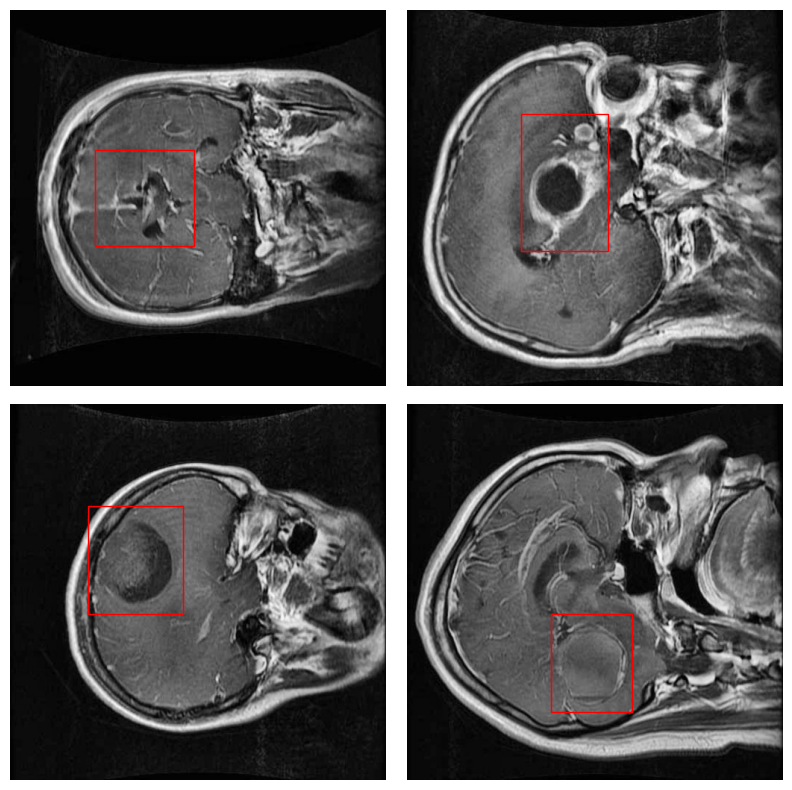

In [7]:
import matplotlib.gridspec as gridspec

def visualize_annotations_grid(data_dir):
    coco_annotations = load_coco_annotations(data_dir)
    coco = COCO(os.path.join(data_dir, '_annotations.coco.json'))

    # Setup the matplotlib grid for 2x2 images
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(2, 2)
    gs.update(wspace=0.05, hspace=0.05)

    # Load and display the first 4 images
    for idx, img_id in enumerate(coco.getImgIds()[:4]):
        img_info = coco.loadImgs(img_id)[0]
        image_path = os.path.join(data_dir, img_info['file_name'])
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_id))
        
        ax = plt.subplot(gs[idx])
        ax.axis('off')
        ax.set_aspect('equal')
        visualize_annotations(image, {'annotations': annotations}, ax)

    plt.show()

# Example usage: Visualize annotations for the first 4 images in a 2x2 grid for the training set
visualize_annotations_grid(data_dirs['train'])
